In [1]:
import netCDF4
from netCDF4 import Dataset
import os
from os.path import dirname
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib 
import matplotlib.pyplot as plt
from math import pi
from numpy import cos,sin
from scipy.spatial import cKDTree
from numpy import absolute as abs
import numpy.ma as ma
import pandas as pd

# Extract climate data 

### Data in netcfd format is processed. Report in correposndence to each num_dataset the correct file. You can run this script multiple times in order to append data retrieved from successive time frames.

In [2]:
## This script allows to open the datasets and store the variables in var_values dictionary.
'''
Datasets:
    1: MaxAirTemp
    2: precipitation
    3: DowShortRadiation
    
'''
# Choose folder where you stored your files here. 
num_dataset=2
folder= r"C:\\Users\\NLLIST\\Desktop\\Thesis\\EUR11-KNMI-CNRM-rcp26\\" 

# Open dataset: report the name of the files only.
if num_dataset == 1:
    file = folder + "tasmax_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp26_r1i1p1_KNMI-RACMO22E_v2_day_20410101-20451231.nc"
    selected_variable = 'tasmax'
    text = 'Max Daily Temperature near surface'
elif num_dataset == 2:
    file = folder + "pr_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp26_r1i1p1_KNMI-RACMO22E_v2_day_20410101-20451231.nc"
    selected_variable = 'pr'
    text = 'Daily Precipitation'
elif num_dataset == 3:
    file = folder + "rsds_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp26_r1i1p1_KNMI-RACMO22E_v2_day_20410101-20451231.nc"
    selected_variable = 'rsds'
    text = 'Monthly Downwelling Shortwave radiation'
    # Since for peak hours 2 datasets are needed, the second is here processed
    file_2= folder + "sund_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp26_r1i1p1_KNMI-RACMO22E_v2_day_20410101-20451231.nc"
    selected_variable_2= 'sund'
    dataset2= Dataset(file_2, "r")
    var_values2 = {}
    var_units2 = {}
    var_names2= {}
    for k in dataset2.variables.keys(): 
        # Standardize keys 'latitude' and 'longitude'
        if k == 'lat':
            k_new = 'latitude'
        elif k == 'lon':
            k_new = 'longitude'
        else:
            k_new = k

        if k == 'rotated_pole':
            var_units2[k_new] = 'degrees' # Save units
            var_names2[k_new] = dataset2.variables[k].grid_mapping_name # Save name
        elif k == 'rotated_latitude_longitude':
            var_units2[k_new] = 'degrees' # Save units
            var_names2[k_new] = dataset2.variables[k].grid_mapping_name # Save name
        elif k== 'time_bnds':   
            var_units2[k_new] = 'days' # Save units
            var_names2[k_new] = 'time bounds' # Save name
        elif k== 'lat_vertices' or k== 'lon_vertices':   
            var_units2[k_new] = dataset2.variables[k].units # Save units
            var_names2[k_new] = 'vertices' # Save name
        else:    
            var_units2[k_new] = dataset2.variables[k].units # Save units
            var_names2[k_new] = dataset2.variables[k].long_name # Save name

        if 'time' in var_names2[k_new]: #Save time
            t_cal = dataset2.variables['time'].calendar
            tvalue = netCDF4.num2date(dataset2.variables['time'][:],var_units2['time'], calendar = t_cal)
            var_values2['time'] = [i.strftime("%Y-%m-%d") for i in tvalue]
        else:
            var_values2[k_new] = dataset2.variables[k][:]    
    
# Store the details of the main dataset    
dataset = Dataset(file, "r")

# Save variables, units and names
var_values = {}
var_units = {}
var_names = {}
for k in dataset.variables.keys():
    # Standardize keys 'latitude' and 'longitude'
    if k == 'lat':
        k_new = 'latitude'
    elif k == 'lon':
        k_new = 'longitude'
    else:
        k_new = k
    

    if k == 'rotated_pole':
        var_units[k_new] = 'degrees' # Save units
        var_names[k_new] = dataset.variables[k].grid_mapping_name # Save name
    elif k == 'rotated_latitude_longitude':
        var_units[k_new] = 'degrees' # Save units
        var_names[k_new] = dataset.variables[k].grid_mapping_name # Save name
    elif k== 'time_bnds':   
        var_units[k_new] = 'days' # Save units
        var_names[k_new] = 'time bounds' # Save name
    elif k== 'lat_vertices' or k== 'lon_vertices':   
        var_units[k_new] = dataset.variables[k].units # Save units
        var_names[k_new] = 'vertices' # Save name
    else:    
        var_units[k_new] = dataset.variables[k].units # Save units
        var_names[k_new] = dataset.variables[k].long_name # Save name
        
    if 'time' in var_names[k_new]: #Save time
        t_cal = dataset.variables['time'].calendar
        tvalue = netCDF4.num2date(dataset.variables['time'][:],var_units['time'], calendar = t_cal)
        var_values['time'] = [i.strftime("%Y-%m-%d") for i in tvalue]
    else:
        var_values[k_new] = dataset.variables[k][:]


    # Remove single-dimensional entries
    #var_values[k_new] = np.squeeze(var_values[k_new])
        


In [9]:
#here you can find the lat and lon of your axis, to be inserted in the webpage that computes the coordinates for your location
print(dataset.variables)

{'rotated_pole': <class 'netCDF4._netCDF4.Variable'>
|S1 rotated_pole()
    grid_mapping_name: rotated_latitude_longitude
    grid_north_pole_latitude: 39.25
    grid_north_pole_longitude: -162.0
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of   used, 'rlon': <class 'netCDF4._netCDF4.Variable'>
float64 rlon(rlon)
    axis: X
    standard_name: grid_longitude
    long_name: longitude in rotated pole grid
    units: degrees
unlimited dimensions: 
current shape = (424,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(rlat, rlon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
unlimited dimensions: 
current shape = (412, 424)
filling on, default _FillValue of 9.969209968386869e+36 used, 'rlat': <class 'netCDF4._netCDF4.Variable'>
float64 rlat(rlat)
    axis: Y
    standard_name: grid_latitude
    long_name: latitude in rotated pole grid
    units: degrees
unlimited

In [4]:
## Check region, NL boundaries are selected

ylat_north = 4.00
ylat_south = 0.86
xlon_east = -5.65
xlon_west = -9.74

# Create empty arrays. later here the subset of the data will be stored.
var_sub=np.full([int(var_values[selected_variable].shape[0]), int(var_values[selected_variable].shape[1]), int(var_values[selected_variable].shape[2])], np.nan)
lat_sub=np.full(int(var_values[selected_variable].shape[1]), np.nan)
lon_sub=np.full(int(var_values[selected_variable].shape[2]), np.nan)

# Check if measurement is between the selected region coordinates: a new matrix var_sub is created for the region, 
# containing only the data for that specific subdomain along with NaNs everywhere else
for j in range(0,int(var_values[selected_variable].shape[2])): #Longitude
    check_lon = var_values['rlon'][j]
               
    for i in range(0,int(var_values[selected_variable].shape[1])): #Latitude
        check_lat = var_values['rlat'][i]
                   
        if check_lat <= ylat_north and check_lat >= ylat_south and check_lon >= xlon_west and check_lon <= xlon_east:      
            lat_sub[i] = check_lat
            lon_sub[j] = check_lon
            var_sub[:,i,j] = var_values[selected_variable][:,i,j]
        else:
            pass
var_sub = ma.masked_values(var_sub, var_values[selected_variable].fill_value)

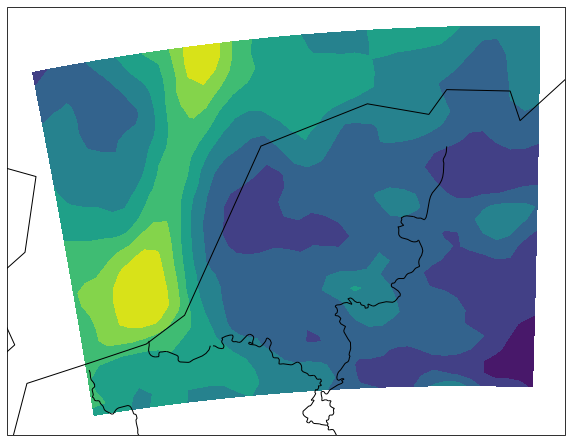

In [5]:
## Plot region data on chosen timestep

# Choose timestep
timestep=18

var_subplot = var_sub[timestep,:,:]

plt.figure(figsize=(10,10))

ax = plt.subplot( projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )

#ax.set_extent([-180,180,-90,-55], ccrs.PlateCarree())

data_crs = ccrs.RotatedPole(pole_longitude=dataset.variables['rotated_pole'].grid_north_pole_longitude,
                            pole_latitude=dataset.variables['rotated_pole'].grid_north_pole_latitude)

levels = [0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)

result=ax.contourf(lon_sub, lat_sub, var_subplot, transform=data_crs)

#plt.colorbar(result, orientation='horizontal', extend='both')

### Choose the coordinates for the location under study

Max W/m2 per day in this location in the Netherlands is 362


Text(0.5, 1.0, 'Plot representing Surface Downwelling Shortwave Radiation in days')

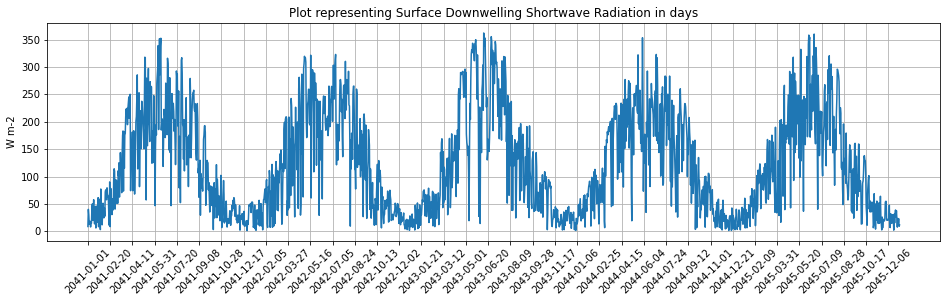

In [5]:
# Time series at given coordinates

#Nan are converted to high number, so that next processes work
lat_sub[np.isnan(lat_sub)]=9999
lon_sub[np.isnan(lon_sub)]=9999


# Choose coordinates (the ones reported here are for Schiedam)
lon = -8.35
lat = 1.94
#lon = -5.39
#lat = 1.88
    
lat_idx = np.abs(lat_sub - lat).argmin()
lon_idx = np.abs(lon_sub - lon).argmin()
#print('Exact Location lat-lon:', [lat,lon])
#print('Closest lat-lon:', var_values['latitude'][lat_idx], var_values['longitude'][lon_idx])
#print('Array indices [iy,ix]=', lat_idx, lon_idx)   

# Get all time records of variable at indices [iy,ix]
if selected_variable== 'tasmax':
    all_records_coordinates = var_values[selected_variable][:,lat_idx,lon_idx]
    all_records_coordinates_celsius = var_values[selected_variable][:,lat_idx,lon_idx]-273.15
elif selected_variable== 'pr':
    all_records_coordinates = var_values[selected_variable][:,lat_idx,lon_idx]
    all_records_coordinates_mm = var_values[selected_variable][:,lat_idx,lon_idx]*60*60*24
elif selected_variable== 'rsds':
    all_records_coordinates = var_values[selected_variable][:,lat_idx,lon_idx]
    maxi=max(var_values[selected_variable][:,lat_idx,lon_idx])
    print('Max W/m2 per day in this location in the Netherlands is %i' % maxi)

# Plot time series
plt.figure(figsize=(16,4))
plt.plot_date(var_values['time'],all_records_coordinates,fmt='-')
plt.grid()
plt.xticks(var_values['time'][::50],rotation=45)
plt.ylabel('%s' % (var_units[selected_variable]))
plt.title('Plot representing %s in %s'% (var_names[selected_variable], var_units['time_bnds']))

#### Extracting heatwaves and hot days

In [6]:
# Heatwaves are defined by the KNMI being 5 consecutive days with Tmax>=25 deg celsius, of which at least 3 with Tmax>=30 deg celsius
if num_dataset==1: 
    
    # Find indices for searched event
    idx=[] 
    for i in range (len(all_records_coordinates_celsius)-4):
        if all(all_records_coordinates_celsius[i:i+5]>=25) and sum(i>=30 for i in all_records_coordinates_celsius[i:i+5])>=3:
            idx.append(i)
            
    # Store days and values for that day that the indices refer to        
    t=[]
    d=[]
    for i in idx: 
        for j in range(4):
            if var_values['time'][i+j] not in t and all_records_coordinates_celsius[i+j] not in d:
                t.append(var_values['time'][i+j])
                d.append(all_records_coordinates_celsius[i+j])
    heatwaves2=np.c_[t,d]
    with open("C:\\Users\\NLLIST\\OneDrive - Sweco AB\\Thesis\\Climate data\\rcp26\\heatwavess2125.csv", 'a') as f:
        np.savetxt(f,heatwaves2, delimiter=",", fmt='%s')
    
#use 'a' in order to append the obtained data to the old one as the eurocordex data comes divided into 5-years groups   

In [7]:
# Days with more than 25 deg celsius are considered to be dangerous too, and green/blue roofs can help
if num_dataset==1: 
    
    # Find indices for events
    t=[] 
    d=[] 
    for i in range(len(all_records_coordinates_celsius)):
        if (all_records_coordinates_celsius[i]>=25):
            t.append(var_values['time'][i])
            d.append(all_records_coordinates_celsius[i])
            
    hot_days=np.c_[t,d]
    
    #print(hot_days)
    with open("C:\\Users\\NLLIST\\OneDrive - Sweco AB\\Thesis\\Climate data\\rcp26\\hotdays.csv", 'a') as f:
        np.savetxt(f,hot_days, delimiter=",", fmt='%s')
    

#### Extracting  heavy rainfall days and mid-intense rainfall

In [8]:
#Rain is considered to be heavy if it is 25mm\hour or 50mm\day
if num_dataset==2:     

    idx=[]
    for i in range (len(all_records_coordinates_mm)):
        if all_records_coordinates_mm[i]>=50:
            idx.append(i)
    t=[]
    d=[]
    for i in idx: 
        t.append(var_values['time'][i])
        d.append(all_records_coordinates_mm[i])
    heavyrain=np.c_[t,d]
    with open("C:\\Users\\NLLIST\\OneDrive - Sweco AB\\Thesis\\Climate data\\rcp26\\heavyrain.csv", 'a') as f:
        np.savetxt(f,heavyrain, delimiter=",", fmt='%s')
    

In [9]:
#Retention achieved by green and blue roofs is considered to be useful starting from 25mm\day
if num_dataset==2:     

# Find indices for events
    t=[] 
    d=[] 
    for i in range(len(all_records_coordinates_mm)):
        if (all_records_coordinates_mm[i]>=25):
            t.append(var_values['time'][i])
            d.append(all_records_coordinates_mm[i])
            
    mediumrain=np.c_[t,d]
    
    #print(hot_days)
    with open("C:\\Users\\NLLIST\\OneDrive - Sweco AB\\Thesis\\Climate data\\rcp26\\mediumrain.csv", 'a') as f:
        np.savetxt(f,mediumrain, delimiter=",", fmt='%s')
        

#### Extracting  sun-peak hours

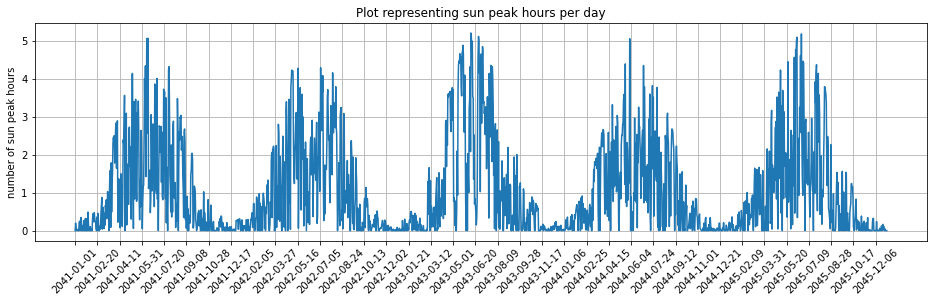

In [10]:
if num_dataset==3: 
    sun_hours=var_values2[selected_variable_2][:,lat_idx,lon_idx]/3600

    sun_peak_hours= (all_records_coordinates)*sun_hours/(1000)
    with open('C:\\Users\\NLLIST\\OneDrive - Sweco AB\\Thesis\\Climate data\\rcp26\\sunpeak.csv', 'a') as f:
          np.savetxt(f,sun_peak_hours, delimiter=',',  fmt='%s')
            
    #plot 
    plt.figure(figsize=(16,4))
    plt.plot_date(var_values['time'],sun_peak_hours,fmt='-')
    plt.grid()
    plt.xticks(var_values['time'][::50],rotation=45)
    plt.ylabel('number of sun peak hours')
    plt.title('Plot representing sun peak hours per day')        
      

### Have a look at the european data

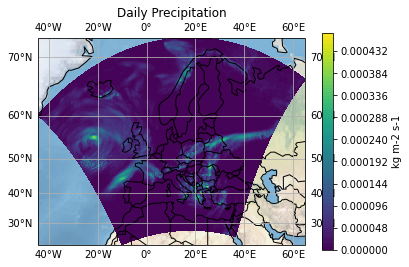

In [6]:
#Plot for EUR
#choose the moment in time
timestep=100

var_plot=var_values[selected_variable][timestep,:,:]

proj=ccrs.Mercator()
m=plt.axes(projection=proj)

m.stock_img()
m.coastlines(resolution='110m')
m.add_feature(cfeature.BORDERS)
gl=m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

gl_xformatter=LONGITUDE_FORMATTER
gl_yformatter=LATITUDE_FORMATTER
gl_xlabels_top= False
gl_tlabels_right= False

plt.contourf(var_values['longitude'], var_values['latitude'], var_plot, 60, transform=ccrs.PlateCarree())
cbar=plt.colorbar()
cbar.set_label(var_units[selected_variable])

plt.title(text)
plt.show()

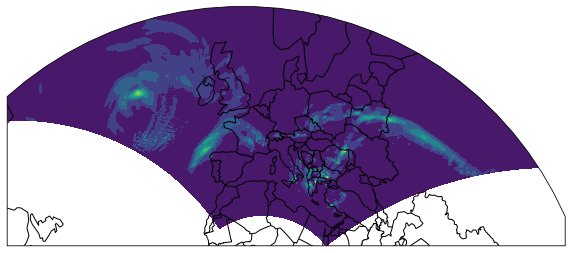

In [7]:
plt.figure(figsize=(10,10))

ax = plt.subplot( projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )

#ax.set_extent([-180,180,-90,-55], ccrs.PlateCarree())

data_crs = ccrs.RotatedPole(pole_longitude=dataset.variables['rotated_pole'].grid_north_pole_longitude,
                            pole_latitude=dataset.variables['rotated_pole'].grid_north_pole_latitude) #change to rotated_pole for other

levels = [0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)

result=ax.contourf(var_values['rlon'], var_values['rlat'], var_plot, transform=data_crs)

#plt.colorbar(result, orientation='horizontal', extend='both')